# QSARtuna CLI Tutorial

## This tutorial

This tutorial is intended to provide a new user with the necessary background to start using QSARtuna through a command line interface (CLI).

A separate tutorial is available describing the use of the QSARtuna GUI.

## Background

QSARtuna is a python package originally developed to automate the model building process for *REINVENT*. These models can use a variety of algorithms to fit to your input data and most of them have one or more so-called hyper-parameters (e.g. the maximum number of trees using a *Random Forest* or the C parameter in SVRs, controlling the influence of every support vector).

For both regression and classification tasks, QSARtuna allows you to specify input data for which the optimal hyper-parameters and a model can obtained automatically. If you want to get an idea on how the package is structured, read on otherwise you might want to skip it and  The following examples should give you an idea how.


### The three-step process

QSARtuna is structured around three steps:
1. **Hyperparameter Optimization:** 
    Train many models with different parameters using Optuna.
    Only the training dataset is used here. 
    Training is usually done with cross-validation.
2. **Build (Training):**
    Pick the best model from Optimization, 
    re-train it without cross-validation,
    and optionally evaluate its performance on the test dataset.
3. **Prod-build (or build merged):** 
    Re-train the best-performing model on the merged training and test datasets. 
    This step has a drawback that there is no data left to evaluate the resulting model, 
    but it has a big benefit that this final model is trained on the all available data.   

## Preparation

To use QSARtuna from Jupyter Notebook, install it with:
```
python -m pip install https://github.com/MolecularAI/QSARtuna/releases/download/3.1.2/qsartuna-3.1.2.tar.gz
```

### Regression example
This is a toy example of training a model that will predict molecular weight for a subset of DRD2 molecules. This example was chosen so that the whole run would take less than a minute.

Training dataset is a CSV file. It has SMILES strings in a column named "canonical". It has the value that we will try to predict in column "molwt".

This example has train and test (holdout) dataset ready. If you have single dataset and would like QSARtuna to split it into train and test (holdout) datasets, see the next section.

Here are a few lines from the input file:

In [1]:
!head  ./train.csv

Smiles,pChEMBL Value,ChEMBL ID
CC1(C)CCc2c(C(=O)Nc3cnn([C@H](c4ccccc4)C4CCS(=O)(=O)C4)c3)n[nH]c2C1,9.3,CHEMBL3426301
CCNC(=O)c1cnc(N)c2c(-c3ccc(NC(=O)Nc4cccc(F)c4)cc3)csc12,8.3,CHEMBL1979516
Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(C)c5)cnc(N)c34)cc2)c1,7.6,CHEMBL1967116
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4,8.1,CHEMBL1980995
CC(=O)NCC(=O)N1C2CCC1c1cc(Nc3ncc(C(F)(F)F)c(NC4CCC4)n3)ccc12,8.4,CHEMBL1983111
CNc1cc(-c2c[nH]c(=O)c(NC(=O)c3ccc(N4CCCCC4)cc3)c2)ccn1,8.15,CHEMBL1765774
CN(C)CC[C@@H](c1cccc(Cl)c1)n1cc(NC(=O)c2n[nH]c3c2CCC(C)(C)C3)cn1,8.92,CHEMBL3298376
CCN(CC)Cc1cc([C@H]2C[C@@H]2C(=O)Nc2nc3ccc(-c4cn[nH]c4)cc3s2)ccc1OC,9.3,CHEMBL3086538
COc1ccc([C@H]2C[C@@H]2C(=O)Nc2nc3ccc(-c4cc[nH]c(=O)c4)cc3s2)cc1,8.18,CHEMBL3086328


### Create configuration

QSARtuna configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [1]:
import sys
sys.path.append(".")

In [2]:
# Start with the imports.
import sklearn
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP

In [4]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="smiles",  # Typical names are "SMILES" and "smiles".
        response_column="dG",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./train.csv",
        test_dataset_file="./test.csv"  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
        PathFP.new()
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        KNeighborsRegressor.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,  # Total number of trials.
        n_startup_trials=50,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

### Run optimization

In [5]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
logging.getLogger("train").disabled = True # Prevent ChemProp from logging
import numpy as np
np.seterr(divide="ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tqdm
from functools import partialmethod, partial
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Prevent tqdm in ChemProp from flooding log

# Avoid decpreciated warnings from packages etc
import warnings
warnings.simplefilter("ignore")
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [6]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2024-12-24 15:38:35,606] A new study created in memory with name: my_study
[I 2024-12-24 15:38:35,666] A new study created in memory with name: study_name_0
[I 2024-12-24 15:38:35,796] Trial 0 finished with value: -20.026756121219233 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 3, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 0 with value: -20.026756121219233.
[I 2024-12-24 15:38:35,864] Trial 1 finished with value: -40.456514281915624 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.039054412752107935, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 3.1242780840717016e-

[I 2024-12-24 15:38:36,728] Trial 18 finished with value: -14.269327415265304 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 18 with value: -14.269327415265304.
[I 2024-12-24 15:38:36,743] Trial 19 finished with value: -20.263003697022324 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.735431606118867, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 18 with value: -14.269327415265304.
[I 2024-12-24 15:38:36,758] Trial 20 finished with value

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-18.17682010730224]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-18.17682010730224]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-16.082793881174968]


[I 2024-12-24 15:38:37,256] Trial 35 finished with value: -19.078678340320494 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.6400992020612235, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:37,272] Trial 36 finished with value: -21.320027602037136 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.8968910439566395, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:37,298] Trial 37 finished with value: -21.00594430574171 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.04458440839692226, 'C_

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-17.19268208158854]


[I 2024-12-24 15:38:37,530] Trial 44 finished with value: -18.883309858405344 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:37,546] Trial 45 finished with value: -40.456516485711354 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 83.87968210939489, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 6.382674443425525e-09, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-18.883309858405344]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-14.269327415265304]
Duplicated trial: 

[I 2024-12-24 15:38:37,802] Trial 53 finished with value: -16.410992282465024 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 31, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:37,822] Trial 54 finished with value: -16.799188887641286 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.8711237521628492, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:37,885] Trial 55 finished with value: -17.30432590193697 and 

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 4, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-19.332943515989584]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-14.008566002650992]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3

[I 2024-12-24 15:38:38,145] Trial 63 finished with value: -14.552762406625279 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:38,157] Trial 64 pruned. Duplicate parameter set
[I 2024-12-24 15:38:38,231] Trial 65 finished with value: -14.092002583193642 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 11, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descr

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-14.552762406625279]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 12, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-14.006967623571214]


[I 2024-12-24 15:38:38,369] Trial 68 finished with value: -14.05323590015545 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 16, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:38,443] Trial 69 finished with value: -14.053235900155448 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 17, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 2

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 17, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-14.053235900155448]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 14, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-14.006460726455634]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1

[I 2024-12-24 15:38:38,671] Trial 75 finished with value: -14.053235900155444 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 18, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 23 with value: -13.812344391319634.
[I 2024-12-24 15:38:38,736] Trial 76 finished with value: -13.779217497998767 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 19, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 7

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 19, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-13.779217497998767]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-13.70498270437164]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba

[I 2024-12-24 15:38:38,982] Trial 83 finished with value: -13.621852629523232 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 13, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83 with value: -13.621852629523232.
[I 2024-12-24 15:38:39,038] Trial 84 finished with value: -14.513554379805447 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 13, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 11, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-13.812344391319634]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 15, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-13.779217497998767]


[I 2024-12-24 15:38:39,283] Trial 90 finished with value: -13.779217497998767 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 24, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83 with value: -13.621852629523232.
[I 2024-12-24 15:38:39,349] Trial 91 finished with value: -13.779217497998767 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-13.779217497998767]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 27, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}, return [-13.77921749799877]


[I 2024-12-24 15:38:39,642] Trial 97 finished with value: -13.779217497998767 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 29, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83 with value: -13.621852629523232.
[I 2024-12-24 15:38:39,709] Trial 98 finished with value: -17.419364451364448 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 29, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83

### Visualize optimization progress

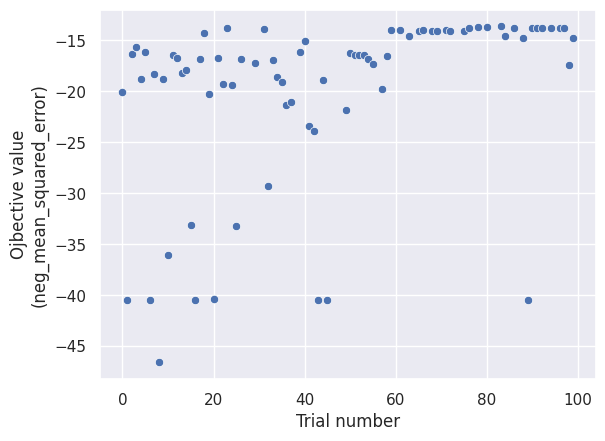

In [7]:
import seaborn as sns
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value");
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (neg_mean_squared_error) for each trial (folds highlighted using different colors).

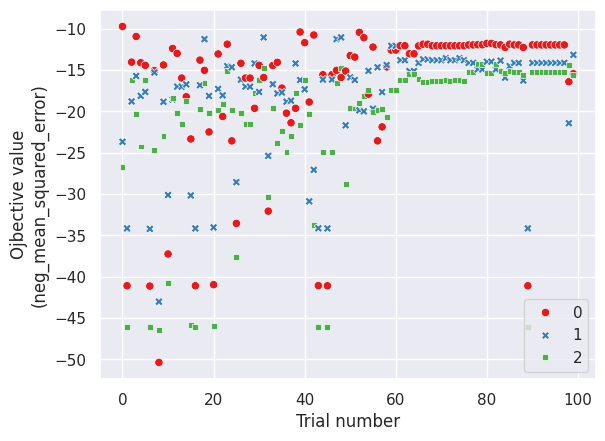

In [8]:
cv_test = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d[default_reg_scoring])
x = []
y = []
fold = []
for i, vs in cv_test.items():
    for idx, v in enumerate(vs):
        x.append(i)
        y.append(v)
        fold.append(idx)
ax = sns.scatterplot(x=x, y=y, hue=fold, style=fold, palette='Set1')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [9]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [10]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

{
  "data": {
    "training_dataset_file": "./train.csv",
    "input_column": "smiles",
    "response_column": "dG",
    "response_type": "regression",
    "deduplication_strategy": {
      "name": "KeepMedian"
    },
    "split_strategy": {
      "name": "NoSplitting"
    },
    "test_dataset_file": "./test.csv",
    "save_intermediate_files": false,
    "log_transform": false,
    "log_transform_base": null,
    "log_transform_negative": null,
    "log_transform_unit_conversion": null,
    "probabilistic_threshold_representation": false,
    "probabilistic_threshold_representation_threshold": null,
    "probabilistic_threshold_representation_std": null
  },
  "metadata": {
    "name": "",
    "cross_validation": 3,
    "shuffle": false,
    "best_trial": 83,
    "best_value": -13.621852629523232,
    "n_trials": 100,
    "visualization": null
  },
  "descriptor": {
    "name": "MACCS_keys",
    "parameters": {}
  },
  "settings": {
    "mode": "regression",
    "scoring": "neg_mean_s

Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [11]:
best_build = build_best(buildconfig, "./best.pkl")

Now we can explore how good the best model performs on the test (holdout) set.

In [29]:
import pickle
with open("./best.pkl", "rb") as f:
    model_best = pickle.load(f)
model_best.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([-22.31363333, -23.94512222])

In [30]:
import pandas as pd

df_best = pd.read_csv(config.data.test_dataset_file)  # Load test data.

expected_best = df_best[config.data.response_column]
predicted_best = model_best.predict_from_smiles(df_best[config.data.input_column])

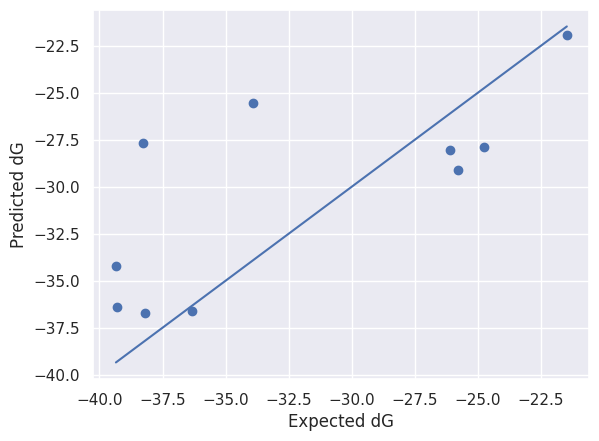

In [31]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_best, predicted_best)
lims = [expected_merged.min(), expected_merged.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

We can also calculate custom metrics for the best model:

In [34]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_best, y_pred=predicted_best)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_best, y_pred=predicted_best))  

# MAE
mae = mean_absolute_error(y_true=expected_best, y_pred=predicted_best)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.44966790190954353, RMSE: 4.9369090207363335, Mean absolute error: 3.7554261111111105


If the metrics look acceptable, the model is ready for use.

### Build merged model

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [35]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "./merged.pkl")

In [40]:
import pickle
with open("./merged.pkl", "rb") as f:
    model_merged = pickle.load(f)
model_merged.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([-21.80875556, -24.62125556])

In [41]:
import pandas as pd

df_merged = pd.read_csv(config.data.test_dataset_file)  # Load test data.

expected_merged = df_merged[config.data.response_column]
predicted_merged = model_merged.predict_from_smiles(df_merged[config.data.input_column])

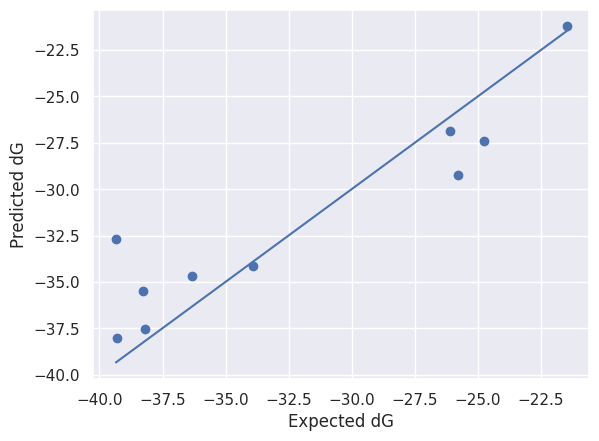

In [42]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_merged, predicted_merged)
lims = [expected_merged.min(), expected_merged.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

In [43]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_merged, y_pred=predicted_merged)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_merged, y_pred=predicted_merged))  

# MAE
mae = mean_absolute_error(y_true=expected_merged, y_pred=predicted_merged)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.8263525612713195, RMSE: 2.773172551970035, Mean absolute error: 2.0386255555555572


# use model

In [45]:
import pickle
with open("./merged.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([-21.80875556, -24.62125556])

In [48]:
df = pd.read_csv('summary.csv')  # Load data.

predicted = model.predict_from_smiles(df['smiles'])
print(predicted)

[-26.86351111 -21.60148889 -25.54291111 -24.88096667 -27.3784
 -22.21335556 -23.84867778 -35.21237778 -23.25791111 -27.83591111
 -24.65901111 -27.48867778 -26.39932222 -29.24852222 -24.55818889
 -24.27235556 -31.11732222 -27.09835556 -23.2933     -23.32342222
 -24.71471111 -29.70864444 -23.32742222 -22.91586667 -23.36328889
 -36.56367778 -17.61593333 -26.58677778 -26.83365556 -31.61725556
 -25.1502     -25.85488889 -14.63648889 -27.41512222 -28.94073333
 -23.08081111 -22.62647778 -21.22406667 -21.79095556 -38.04585556
 -35.44583333 -25.81492222 -20.97365556 -19.75926667 -31.51952222
 -28.27077778 -30.1027     -23.09251111 -26.06934444 -24.66792222
 -29.25865556 -20.43672222 -23.7695     -17.02826667 -23.63564444
 -20.55823333 -25.39624444 -29.07976556 -25.40682222 -28.50966389
 -28.27396389 -27.5525     -27.39188889 -28.773475   -28.71512667
 -26.38225278 -27.26205556 -26.45211111 -31.23296667 -25.06294444
 -24.67741111 -31.40245556 -29.07976556 -27.82798889 -25.868
 -29.15256667 -20.4

In [53]:
df['qsar'] = predicted

In [55]:
df.to_csv('summary.csv')